### Logistic Regression Credit Risk

Dataset generado de forma aleatoria para efectos educativos.

### Paos


In [ ]:
''' 
pip install xgboost scikit-learn
pip install graphviz xgboost
'''

In [1]:
pwd

'/Users/michael/Documents/Python/ProyestosPersonales/Modelos/statistical_models/xgboots/01 - Credit_risk_model/NOTEBOOKS'

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [3]:
# Leer el archivo CSV generado en un DataFrame
data = pd.read_csv('/Users/michael/Documents/Python/ProyestosPersonales/Modelos/statistical_models/xgboots/01 - Credit_risk_model/DATA/dataset_crediticio.csv',sep=';')
# Transformar los nombres de las columnas a minúsculas
data.columns = [column.lower() for column in data.columns]
data.shape

(10000, 16)

In [4]:
data.head(3)

,id,edad,ingresos_anuales,historial_crediticio,monto_del_prestamo,plazo_del_prestamo,tasa_de_interes,deuda_existente,numero_de_dependientes,estado_laboral,proposito_del_prestamo,estado_civil,nivel_de_educacion,score_de_riesgo_interno,resultado_del_riesgo,periodo
0,1,31,"$78,719.00",Bueno,"$35,098.00",30,11.8%,"$10,438.00",3,Autónomo,Otros,Divorciado,Maestría,507,1,2022-06
1,2,29,"$43,660.00",Regular,"$43,304.00",34,7.4%,"$1,581.00",0,Desempleado,Emergencia,Divorciado,Maestría,804,1,2022-05
2,3,58,"$56,278.00",Malo,"$12,629.00",9,10.9%,"$24,983.00",5,Desempleado,Auto,Soltero,Preparatoria,629,1,2022-04


In [5]:
# Tasa de malos
bad_rate = data['resultado_del_riesgo'].value_counts().reset_index()
bad_rate = bad_rate.rename(columns={'index': 'Categorias', 'resultado_del_riesgo': 'Qtd'})
bad_rate['%'] = round(bad_rate['Qtd'] / bad_rate['Qtd'].sum(), 1) * 100
bad_rate

,Categorias,Qtd,%
0,1,8892,90.0
1,0,1108,10.0


### Transformación en WoEs

In [6]:
# Definir las categorías y calcular el WOE para una variables independientes
def calcular_woe_variable(variable, target):
    tabla_frecuencia = data.groupby([variable, target]).size().unstack()
    total_buenos = tabla_frecuencia[1].sum()
    total_malos = tabla_frecuencia[0].sum()

    woe = {}
    iv = 0

    for categoria in tabla_frecuencia.index:
        evento_malo = tabla_frecuencia.loc[categoria, 0]
        evento_bueno = tabla_frecuencia.loc[categoria, 1]

        woe[categoria] = round((evento_malo / total_malos) / (evento_bueno / total_buenos), 2)
        iv += ((evento_malo / total_malos) - (evento_bueno / total_buenos)) * woe[categoria]

    return woe

# Lista de variables independientes para transformar
variables_independientes = ['edad','historial_crediticio','plazo_del_prestamo','tasa_de_interes',
'numero_de_dependientes','estado_laboral','proposito_del_prestamo','estado_civil','nivel_de_educacion']

# Transformar las variables independientes en WOE
for variable in variables_independientes:
    woe_dict = calcular_woe_variable(variable, 'resultado_del_riesgo')
    data[variable + '_WOE'] = data[variable].map(woe_dict)

In [7]:
data.head(3)

,id,edad,ingresos_anuales,historial_crediticio,monto_del_prestamo,plazo_del_prestamo,tasa_de_interes,deuda_existente,numero_de_dependientes,estado_laboral,...,periodo,edad_WOE,historial_crediticio_WOE,plazo_del_prestamo_WOE,tasa_de_interes_WOE,numero_de_dependientes_WOE,estado_laboral_WOE,proposito_del_prestamo_WOE,estado_civil_WOE,nivel_de_educacion_WOE
0,1,31,"$78,719.00",Bueno,"$35,098.00",30,11.8%,"$10,438.00",3,Autónomo,...,2022-06,1.01,1.00,0.78,0.84,0.89,1.0,0.90,0.96,1.03
1,2,29,"$43,660.00",Regular,"$43,304.00",34,7.4%,"$1,581.00",0,Desempleado,...,2022-05,0.76,0.97,1.08,1.40,0.94,1.0,0.94,0.96,1.03
2,3,58,"$56,278.00",Malo,"$12,629.00",9,10.9%,"$24,983.00",5,Desempleado,...,2022-04,0.89,1.03,0.97,0.59,1.02,1.0,1.04,1.04,0.99


In [8]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          10000 non-null  int64  
 1   edad                        10000 non-null  int64  
 2   ingresos_anuales            10000 non-null  object 
 3   historial_crediticio        10000 non-null  object 
 4   monto_del_prestamo          10000 non-null  object 
 5   plazo_del_prestamo          10000 non-null  int64  
 6   tasa_de_interes             10000 non-null  object 
 7   deuda_existente             10000 non-null  object 
 8   numero_de_dependientes      10000 non-null  int64  
 9   estado_laboral              10000 non-null  object 
 10  proposito_del_prestamo      10000 non-null  object 
 11  estado_civil                10000 non-null  object 
 12  nivel_de_educacion          10000 non-null  object 
 13  score_de_riesgo_interno     1000

### Calculo de iv

In [9]:
tabla_frecuencia = data.groupby([variable, 'resultado_del_riesgo']).size().unstack()
total_buenos = tabla_frecuencia[1].sum()
total_malos = tabla_frecuencia[0].sum()
# Crear una lista para almacenar los valores de IV por variable
iv_summary = []

# Calcular y mostrar el WOE y el IV para cada variable
for variable in variables_independientes:
    woe_dict = calcular_woe_variable(variable, 'resultado_del_riesgo')
    data[variable + '_WOE'] = data[variable].map(woe_dict)

    iv = 0
    for categoria, woe in woe_dict.items():
        evento_malo = data[data[variable] == categoria]['resultado_del_riesgo'].sum()
        evento_bueno = data[data[variable] == categoria]['resultado_del_riesgo'].count() - evento_malo

        iv += ((evento_malo / total_malos) - (evento_bueno / total_buenos)) * woe

    iv_summary.append({'Variable': variable, 'IV': iv})

# Crear un DataFrame para mostrar la tabla resumen de IV
iv_data = pd.DataFrame(iv_summary)

# Ordenar el DataFrame por IV en orden descendente
iv_data = iv_data.sort_values(by='IV', ascending=False)

# Mostrar la tabla resumen de IV
iv_data

,Variable,IV
5,estado_laboral,7.926616
6,proposito_del_prestamo,7.904271
4,numero_de_dependientes,7.902440
8,nivel_de_educacion,7.899854
2,plazo_del_prestamo,7.899711
7,estado_civil,7.898386
1,historial_crediticio,7.897124
0,edad,7.889817
3,tasa_de_interes,7.886394


In [10]:
# Filtrar las columnas que terminan con "_woe" más el target
data = data.filter(regex='_WOE$|resultado_del_riesgo|periodo')
data.head(3)

,resultado_del_riesgo,periodo,edad_WOE,historial_crediticio_WOE,plazo_del_prestamo_WOE,tasa_de_interes_WOE,numero_de_dependientes_WOE,estado_laboral_WOE,proposito_del_prestamo_WOE,estado_civil_WOE,nivel_de_educacion_WOE
0,1,2022-06,1.01,1.00,0.78,0.84,0.89,1.0,0.90,0.96,1.03
1,1,2022-05,0.76,0.97,1.08,1.40,0.94,1.0,0.94,0.96,1.03
2,1,2022-04,0.89,1.03,0.97,0.59,1.02,1.0,1.04,1.04,0.99


In [11]:
def get_na(data):
    qsna = data.shape[0] - data.isnull().sum(axis = 0) #Cantidad de NA
    qna = data.isnull().sum(axis = 0)
    ppna = round(100*(qna/data.shape[0]),2)
    aux = {'Datos sin Nas en qtd': qsna, 'Na en qtd': qna, 'Na en %': ppna}
    na = pd.DataFrame(data = aux)
    return na.sort_values(by = 'Na en qtd', ascending = False)

In [12]:
get_na(data)

,Datos sin Nas en qtd,Na en qtd,Na en %
resultado_del_riesgo,10000,0,0.0
periodo,10000,0,0.0
edad_WOE,10000,0,0.0
historial_crediticio_WOE,10000,0,0.0
plazo_del_prestamo_WOE,10000,0,0.0
tasa_de_interes_WOE,10000,0,0.0
numero_de_dependientes_WOE,10000,0,0.0
estado_laboral_WOE,10000,0,0.0
proposito_del_prestamo_WOE,10000,0,0.0
estado_civil_WOE,10000,0,0.0


In [13]:
# Guardar el conjunto de datos transformado en un nuevo archivo parquet
data.to_parquet('/Users/michael/Documents/Python/ProyestosPersonales/Modelos/statistical_models/xgboots/01 - Credit_risk_model/DATA/dataset_crediticio_Logict_woe.parquet', index=False)

### Logistic Regression

In [14]:
# Dividir los datos en conjunto de entrenamiento y prueba
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
print(train_data.shape)
print(test_data.shape)

(8000, 11)
(2000, 11)


In [15]:
# Definir las columnas predictoras (características) y la variable objetivo
features = ['edad_WOE','historial_crediticio_WOE','plazo_del_prestamo_WOE','tasa_de_interes_WOE',
'numero_de_dependientes_WOE','estado_laboral_WOE','proposito_del_prestamo_WOE','estado_civil_WOE',
'nivel_de_educacion_WOE']
target = 'resultado_del_riesgo'

In [16]:
# Crear el modelo de regresión logística
model = LogisticRegression()

In [17]:
# Entrenar el modelo en el conjunto de entrenamiento
model.fit(train_data[features], train_data[target])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [18]:
# Evaluar el modelo en el conjunto de prueba
probabilities = model.predict_proba(test_data[features])[:, 1]
roc_auc = roc_auc_score(test_data[target], probabilities)

In [19]:
# Calcular las métricas de KS y Gini
fpr, tpr, _ = roc_curve(test_data[target], probabilities)
ks = max(tpr - fpr)
gini = 2 * roc_auc - 1

In [20]:
# Imprimir métricas
print("AUC-ROC:", roc_auc)
print("KS:", ks)
print("Gini:", gini)

AUC-ROC: 0.6096736507196427
KS: 0.1754534689346957
Gini: 0.2193473014392855


In [21]:
# Calcular el score para cada cliente
train_data['score'] = np.round(model.predict_proba(train_data[features])[:, 1]*1000)

In [23]:
train_data.shape

(8000, 12)

In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

# Dividir los datos en deciles naturales según el 'score'
train_data['Decil'] = pd.qcut(train_data['score'], q=10, labels=False)

# Calcular las métricas por decil
summary_table = train_data.groupby('Decil').agg({
    'score': ['min', 'max'],
    'resultado_del_riesgo': ['sum', lambda x: len(x) - sum(x)],
})

# Renombrar columnas
summary_table.columns = ['Min Probabilidad', 'Max Probabilidad', 'Eventos', 'No Eventos']

# Calcular tasas y acumulados
summary_table['Event Rate'] = summary_table['Eventos'] / (summary_table['Eventos'] + summary_table['No Eventos'])
summary_table['No Event Rate'] = 1 - summary_table['Event Rate']
summary_table['Cumulative Event Rate'] = summary_table['Eventos'].cumsum() / summary_table['Eventos'].sum()
summary_table['Cumulative No Event Rate'] = summary_table['No Eventos'].cumsum() / summary_table['No Eventos'].sum()

# Calcular el KS
summary_table['KS'] = np.abs(summary_table['Cumulative Event Rate'] - summary_table['Cumulative No Event Rate'])

# Encontrar el índice del máximo KS
max_ks_index = summary_table['KS'].idxmax()

# Crear la función de formato para resaltar el máximo KS en verde
def highlight_max_ks(s):
    is_max = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]

# Aplicar el formato al DataFrame
formatted_table = summary_table.style.apply(highlight_max_ks, subset=['KS'])

formatted_table

,Min Probabilidad,Max Probabilidad,Eventos,No Eventos,Event Rate,No Event Rate,Cumulative Event Rate,Cumulative No Event Rate,KS
Decil,,,,,,,,,
0,574.000000,825.000000,643,166,0.794808,0.205192,0.090525,0.185061,0.094536
1,826.000000,854.000000,659,132,0.833123,0.166877,0.183303,0.332219,0.148916
2,855.000000,873.000000,723,120,0.857651,0.142349,0.285091,0.465998,0.180907
3,874.000000,887.000000,681,89,0.884416,0.115584,0.380966,0.565217,0.184252
4,888.000000,898.000000,732,96,0.884058,0.115942,0.484021,0.672241,0.188220
5,899.000000,908.000000,774,74,0.912736,0.087264,0.592989,0.754738,0.161749
6,909.000000,917.000000,680,74,0.901857,0.098143,0.688723,0.837235,0.148512
7,918.000000,926.000000,752,62,0.923833,0.076167,0.794594,0.906355,0.111761
8,927.000000,937.000000,716,49,0.935948,0.064052,0.895396,0.960981,0.065585


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

# Supongamos que ya has cargado y preprocesado tus datos y has entrenado el modelo

# Calcular el score para cada cliente en el DataFrame 'train_data'
train_data['score'] = model.predict_proba(train_data[features])[:, 1]

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(train_data['resultado_del_riesgo'], train_data['score'])
roc_auc = auc(fpr, tpr)

# Calcular las métricas de KS en cada decil
grouped = train_data.groupby('decil', as_index=False).agg({'resultado_del_riesgo': 'mean', 'score': 'mean'})
ks_by_decil = np.abs(grouped['resultado_del_riesgo'] - grouped['score'])
ks_max = max(ks_by_decil)

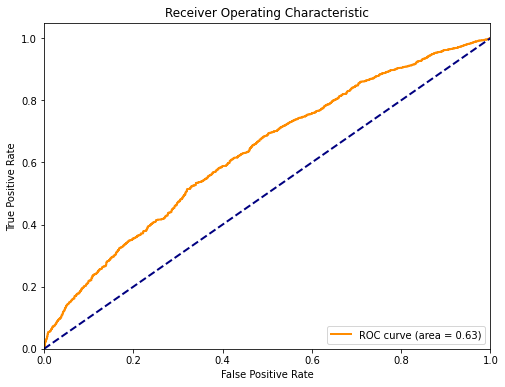

In [51]:
# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

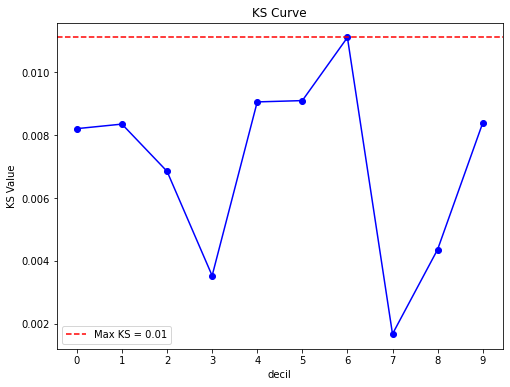

In [52]:
# Graficar la curva KS
plt.figure(figsize=(8, 6))
plt.plot(grouped['decil'], ks_by_decil, marker='o', color='b')
plt.axhline(ks_max, color='r', linestyle='--', label='Max KS = {:.2f}'.format(ks_max))
plt.xlabel('decil')
plt.ylabel('KS Value')
plt.title('KS Curve')
plt.xticks(grouped['decil'])
plt.legend()
plt.show()